In [1]:
# 多项式回归
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 生成数据集
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.7005],
         [-1.0441]]),
 tensor([[ 1.0000e+00, -7.0049e-01,  2.4534e-01, -5.7286e-02,  1.0032e-02,
          -1.4055e-03,  1.6408e-04, -1.6420e-05,  1.4377e-06, -1.1190e-07,
           7.8386e-09, -4.9917e-10,  2.9138e-11, -1.5701e-12,  7.8559e-14,
          -3.6686e-15,  1.6061e-16, -6.6181e-18,  2.5755e-19, -9.4953e-21],
         [ 1.0000e+00, -1.0441e+00,  5.4503e-01, -1.8968e-01,  4.9510e-02,
          -1.0338e-02,  1.7990e-03, -2.6832e-04,  3.5018e-05, -4.0624e-06,
           4.2414e-07, -4.0257e-08,  3.5026e-09, -2.8130e-10,  2.0978e-11,
          -1.4602e-12,  9.5282e-14, -5.8518e-15,  3.3943e-16, -1.8652e-17]]),
 tensor([3.0724, 0.7547]))

In [4]:
# 对模型进行训练和测试
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
# 定义训练函数
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.020603   1.1889309 -3.4315736  5.585212 ]]


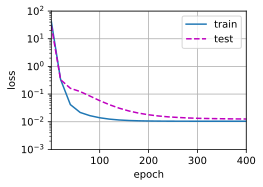

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.664941  6.5626636]]


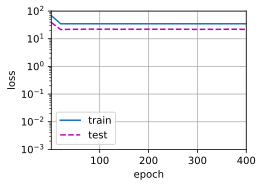

In [7]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9969893   1.221811   -3.2910502   5.4358296  -0.6444738  -0.04614946
   0.5950079  -0.3167067   0.14001538 -0.28742284  0.11011957  0.16373311
   0.10973419  0.0793552  -0.06155996  0.08599908 -0.06580147 -0.18386863
   0.18215899 -0.13609885]]


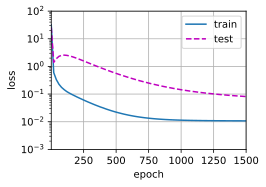

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)